Author: Lauren M. Sanders

Date: April 2020

Treehouse Childhood Cancer Initiative

University of California, Santa Cruz 

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import itertools
import numpy as np
import random
import scanpy as sc
import math

from collections import defaultdict
from scipy.cluster.hierarchy import dendrogram, set_link_color_palette
import fastcluster
from fastcluster import linkage
from matplotlib.colors import rgb2hex, colorConverter
from matplotlib.pyplot import figure

In [2]:
print(sc.__version__)

1.4.6


# Files

## Bulk Glioma RNA-seq
Source: Treehouse Cancer Compendium treehousegenomics.soe.ucsc.edu/public-data/

In [137]:
# bulk glioma RNA-seq matrix
phgg = pd.read_csv('files/pHGG.exp.log2tpm1.tsv',sep='\t',index_col=0)
phgg.shape

(58581, 78)

In [138]:
# bulk glioma metadata dictionary
phggDict = pd.read_csv('files/pHGG.metadata.csv').set_index('THID')['HistoneStatus'].to_dict()
len(phggDict)

78

## Single cell glioma RNA-seq
Source: GSE102130, PMID: 29674595

In [141]:
# filtered to remove 20% of lowest varying genes and genes not expressed in 80% of samples 
scGlioma = pd.read_csv('files/glioma.sc.filtered.log2.tsv',sep='\t',index_col=0)
scGlioma.shape

(10132, 3057)

In [142]:
scGliomaDict = pd.read_csv('files/glioma.sc.meta.csv',index_col=0)['Histone'].to_dict()
len(scGliomaDict)

3057

## Glioma cell line RNA-seq
Source: dbGap phs000900.v1.p1, PMID: 25939062

In [143]:
cl = pd.read_csv('files/glioma.celllines.filtered.log2.tsv',sep='\t',index_col=0)
cl.shape

(24658, 11)

In [144]:
clDict = {
'THR13_0968_S03':'H3.3',
'THR13_0968_S04':'H3.3',
'THR13_0968_S05':'H3.3',
'THR13_0968_S06':'H3.3',

'THR13_0970_S02':'H3.1',
'THR13_0970_S03':'H3.1',
'THR13_0970_S04':'H3.1',
'THR13_0970_S05':'H3.1',

'THR13_0975_S01':'H3.3',
'THR13_0975_S02':'H3.3',
'THR13_0975_S03':'H3.3'
}

## Gene Lists

In [145]:
# list of genes differentially expressed by limma
limma = list(pd.read_csv('files/pHGG.limma.csv',index_col=0).index)
len(limma)

1905

In [146]:
# list of genes overexpressed in H3K27M bulk glioma cohort
lim = pd.read_csv('files/pHGG.limma.csv',index_col=0)
k27mUp = list(lim[(lim['DEStatus'] > 0)].index)
len(k27mUp)

1180

In [147]:
# EMT master gene list 
emtMaster = list(pd.read_csv('files/EMT.masterlist.txt',index_col=0,header=None).index)
len(emtMaster)

1226

In [148]:
# EMT differentially expressed genes
emtDE = [x for x in limma if x in emtMaster]
len(emtDE)

123

In [149]:
# EMT completeness gene list 
emtCom = list(pd.read_csv('files/EMT.completeness.txt',index_col=0,header=None).index)
len(emtCom)

7

In [97]:
# Write out list of genes overexpressed in H3K27M bulk glioma cohort 
# that also pass organoid single cell expression filters
with open('files/DE.UpinK.inOrganoids.041920.txt', 'w') as out:
    out.write('\n'.join(list(scOrgFil.loc[scOrgFil.index.intersection(k27mUp)].index)))

## Bulk organoid RNA-seq
Source: GSE106245

In [13]:
bulk = pd.read_csv("files/organoid.bulk.log2tpm1.tsv",sep="\t",index_col=0)

In [14]:
# converted to gestational weeks
bulkDict = {}
bulkDict['w0 TPM'] = '1'
bulkDict['w1 TPM'] = '2'
bulkDict['w2 TPM'] = '3'
bulkDict['w3 TPM'] = '4'
bulkDict['w4 TPM'] = '5'
bulkDict['w5 TPM'] = '6'


In [15]:
# normalize each row between 0-1 
bulkNorm = bulk.subtract(bulk.min(axis=1), axis=0)\
  .divide(bulk.max(axis=1) - bulk.min(axis=1), axis=0)\
  .combine_first(bulk)


## Single cell organoid RNA-seq
Source: GSE106245

In [35]:
# unfiltered data (scanpy object created by merging the week2 and week5 expression)
scOrgAdata = sc.read_h5ad('files/organoid_raw_wk2wk5.h5ad')
# extract matrix
scOrg = pd.DataFrame(scOrgAdata.X, 
                     index=list(scOrgAdata.obs.index), 
                     columns=list(pd.DataFrame(scOrgAdata.var).index)).transpose()
scOrg.shape


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


(59042, 7650)

In [53]:
# filter to remove 20% of lowest varying genes and genes not expressed in 90% of samples 
genesToKeep = list(make_expr_var_filters(scOrg, 0.9, 0.2, 0).index)
scOrgFil = scOrg.loc[genesToKeep] # subset to genes that passed filters
scOrgFil = scOrgFil.groupby(scOrgFil.index).mean() # average any duplicate genes
scOrgFil.shape

7863 genes remain after expression filter.
6290 genes remain after variance filter.


(6290, 7650)

In [130]:
# create cell type dictionary, rename cell types for correct plotting order
scOrgDict = {}
with open('files/celltypes_wk2wk5_names.csv', 'r') as f:
    for line in f:
        line = line.rstrip().split(',')
        if line[1] == 'Neuroepithelium':
            scOrgDict[line[0]] = 'ANeural \nepithelium'
        if line[1] == 'Early radial glia':
            scOrgDict[line[0]] = 'Early \nradial glia'
        if line[1] == 'Intermediate Progenitors':
            scOrgDict[line[0]] = 'Intermediate \nprogenitors'
        if line[1] == 'Late radial glia':
            scOrgDict[line[0]] = 'Late \nradial glia'
        if line[1] == 'Neurons':
            scOrgDict[line[0]] = 'Neurons'       
len(scOrgDict)

7257

# Functions

In [56]:
# statistical annotation for boxplots
%run ./files/statannot.py

In [57]:
# Code sourced from Treehouse CARE 

def make_expr_var_filters(dataframe, proportion_unexpressed, filter_level, zero_threshold):
    
    # unroll the count of zeroes
    max_ok_zeroes = len(dataframe.columns) * proportion_unexpressed

    # Is the count of items less than threshold within the acceptable count?
    def sufficiently_expressed(series, max_zeroes,threshold):
            return len(series[series <= threshold]) < max_zeroes

    # Gene & whether it is Keep (True) or too many zeroes (False)    
    withZeroes = dataframe.apply(sufficiently_expressed,
                            args=(max_ok_zeroes, zero_threshold),
                            axis=1)

    # Next, do variance filtering
    expression_filtered_compendium = dataframe[withZeroes]
    print(str(len(expression_filtered_compendium)) + ' genes remain after expression filter.')

    # Get the standard deviation
    variance = expression_filtered_compendium.apply(np.std, axis=1)
    cut_proportion = int(math.ceil(len(variance)*filter_level))
    keep_proportion = len(variance) - cut_proportion
    expression_and_variance_filtered = variance.nlargest(keep_proportion)
    print(str(len(expression_and_variance_filtered)) + ' genes remain after variance filter.')

    return expression_and_variance_filtered

In [127]:
def Heatmap(df, geneList, dictionary, title, filename, font, figuresize, pal, 
            colormap, geneCluster, vMinMax, ticks):
    '''
    Input: 
    1) df = the expression df (pandas df)
    2) geneList = list of genes 
    3) dictionary = dictionary to color groups 
    4) title = title for the plot (string)
    5) filename = filename to save figure (string path)
    6) font = font size (integer)
    7) seaborn color pallette (list)
    8) heatmap colors (string)
    9) whether to cluster rows (bool)
    10) vMinMax = a tuple, values to anchor the colormap (None,None) if none
    11) ticks = colorbar ticks, a list with 2 integers [0,1]
    '''

    sns.set(font_scale=font)
    # subset and reorder expression by genelist and dict samples
    dfSub = df.loc[df.index.intersection(geneList)].reindex(geneList)[list(dictionary.keys())] 
    dfSub.head()
    
    # Reorder expression with sample info from the dictionary
    stat = pd.DataFrame(pd.Series(dictionary))
    stat.rename(columns={ stat.columns[0]: "Status" }, inplace=True)
    stat.sort_values(by="Status", inplace=True)
    dfSub = dfSub.reindex(columns=list(stat.index))
    statOnly = stat.pop('Status')
    
    # Heatmap
    lut = dict(zip(statOnly.unique(), pal))
    col_colors = statOnly.map(lut)   

    g = sns.clustermap(dfSub, cmap=colormap,
                        z_score=0, col_colors=col_colors, xticklabels=False, yticklabels=False,
                       vmin=vMinMax[0], vmax=vMinMax[1], cbar_kws={"ticks":ticks},
                        col_cluster=False, row_cluster=geneCluster, metric='correlation',
                       robust=True, square=False, figsize=figuresize)
   
    plt.savefig(filename,dpi=300,bbox_inches="tight")

In [132]:
def Boxplot(df, geneName, dictionary, title, yaxis, filename, figuresize, color, swarmSize):
    '''
    1) expression pandas dataframe
    2) name of gene to plot (string)
    3) dictionary for grouping samples 
    4) plot title (string)
    5) y axis title (string)
    6) filename to save figure (string path)
    7) seaborn color pallette (list)
    8) figure size (tuple)
    9) size of swarmplot dots
    '''
    
    sns.set(style="white", font_scale=1.1)
    sns.set_palette(color)
    fig, ax = plt.subplots(figsize=figuresize)
    
    plt.rc('font', size=20)          
    plt.rc('xtick', labelsize=25)    
    plt.rc('ytick', labelsize=25)    
    
    status = []
    values = []
    
    # Subset the expression df by gene and dictionary samples 
    dfSub = df.loc[[geneName]][list(dictionary.keys())]

    # Expression values to plot
    values = dfSub.loc[geneName].values.tolist()
    
    # Sample status for plotting 
    for name in list(dfSub.columns.values):
        if name in dictionary.keys():
            status.append(dictionary[name])
    
    plot_df = pd.DataFrame({'Status': status,'Value': values}, columns = ['Status','Value']).sort_values(by=['Status'])

    # Plot boxplot and swarmplot
    ax = sns.boxplot(ax=ax, x="Status", y="Value", hue="Status", data=plot_df, dodge=False, fliersize=2).set_title(title)
    ax = sns.swarmplot(x="Status", y="Value", color="black", data=plot_df, size=swarmSize)

    # Add statistical annotations
    orderForStatAnnot = list(itertools.combinations( list(sorted(plot_df['Status'].unique())), 2))
    add_stat_annotation(ax, data=plot_df, x="Status", y="Value", order=list(sorted(plot_df['Status'].unique())),
                    boxPairList=orderForStatAnnot, 
                    test='Mann-Whitney', textFormat='star', loc='inside', verbose=0)
                        
    sns.despine(offset=10, trim=True)
    ax.legend_.remove()
    ax.set_ylabel(yaxis, fontsize=30)
    ax.set_xlabel('')
    ax.set_title(title,fontsize=30)

    plt.savefig(filename,dpi=500,bbox_inches='tight')

In [60]:
def Swarmplot(df, geneName, dictionary, filename, dotColor):
    '''
    Inputs: 
    1) expression pandas dataframe
    2) gene name to plot (string)
    3) status dictionary for plotting
    4) filename (path string)
    5) a matplotlib color (string)
    '''
    
    fig_dims = (5,2) # for bulk RNA data from Field, fig2
    fig, ax = plt.subplots(figsize=fig_dims)
    
    status = []
    values = []
    
    # Subset the expression df by gene and dictionary samples 
    dfSub = df.loc[[geneName]][list(dictionary.keys())]

    # Expression values to plot
    values = dfSub.loc[geneName].values.tolist()
    
    # Sample status for plotting
    for name in list(dfSub.columns.values):
        if name in dictionary.keys():
            status.append(dictionary[name])
    
    plot_df = pd.DataFrame({'Status': status,'Value': values}, columns = ['Status','Value']).sort_values(by=['Status'])
    
    ax = sns.swarmplot(x="Status", y="Value", color=dotColor, data=plot_df, size=20) # normal size=3 #color=".25", 

    plt.rc('xtick', labelsize=25) 
    plt.rc('ytick', labelsize=25)  
    
    sns.despine(offset=10, trim=True)
    sns.despine(trim=False)
    ax.set(xlabel='',ylabel='')
    plt.savefig(filename,dpi=500,bbox_inches='tight')

In [74]:
def scoreCells(df, geneList):
    '''
    Inputs:
    1) expression pandas dataframe
    2) list of genes to use for scoring
    Outputs: a dataframe of normalized scores by cells
    '''
    
    #####################################
    # Create 30 Gene Bins by Expression #
    #####################################

    # Calculate aggregate expression for each gene in new dataframe
    agdf = pd.DataFrame(index=df.index)
    agdf['aggregate'] = df.mean(axis=1)
    agdf = agdf.sort_values(by='aggregate')

    # Get bin edges for 30 bins
    binSize = round(len(list(agdf['aggregate']))/30)
    i = 1
    j = 0
    bins = []
    bins.append(0.0)
    for j in range(1, 31):
        if j < 30:
            bins.append(list(agdf['aggregate'])[i*binSize])
        elif j == 30:
            bins.append( round(df.values.max()) ) 
        i += 1
    
    # Assign genes to bins based on aggregate expression
    labels = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
    agdf['binned'] = pd.cut(agdf['aggregate'], bins=bins, labels=labels)
    
    # Make a dictionary relating gene and bin number
    binDict = agdf['binned'].to_dict() 
    
    # Make a dictionary relating bin and expression interval
    intervalDict = {}
    i = 0
    for x in bins: 
        try:
            intervalDict[i+1] = (x,bins[i+1])
            i += 1
        except IndexError:
            pass

    # Function to return the bin for each gene's expression in one cell
    def getBin(geneExp):
        for x in intervalDict:
            interval = intervalDict[x]
            if geneExp >= interval[0] and geneExp <= interval[1]:
                return(x)
 
    ###############################
    # Calculate Scores Using Bins #
    ###############################
            
    scoreDict = {}
    columns = list(df) 
    
    # Iterate through samples
    i = 0 
    for sam in columns:
        # Calculate non-normalized score 
        prelimScore = np.mean(list(df[sam].loc[df.index.intersection(geneList)])) 
        
        # Get control gene set (100 random genes from each real gene's bin)
        ctrlGeneSet = []    
        for gene in list(df[sam].loc[df.index.intersection(geneList)].index) : 
            geneBin = getBin( df[sam].loc[df.index.intersection(geneList)].loc[gene]  ) 
            ctrlGeneSet.extend(random.sample([x for x in list(binDict.keys()) if binDict[x] == geneBin], 100)) 
        
        # Calculate score for control gene set
        ctrlScore = np.mean(list(df[sam].loc[df.index.intersection(ctrlGeneSet)]))
        
        # Normalize score by control score and add to dictionary
        realScore = prelimScore - ctrlScore 
        scoreDict[sam] = realScore

        i += 1 
        if i == len(columns):
            break 
        
    # Convert scores dictionary to dataframe
    scores = pd.DataFrame.from_dict(scoreDict, orient = 'index').T
    
    # Normalize scores between 0-1 
    scoresNorm = scores.subtract(scores.min(axis=1), axis=0)\
      .divide(scores.max(axis=1) - scores.min(axis=1), axis=0)\
      .combine_first(scores)
    
    return(scoresNorm)

# Figure 1

## Figure 1B

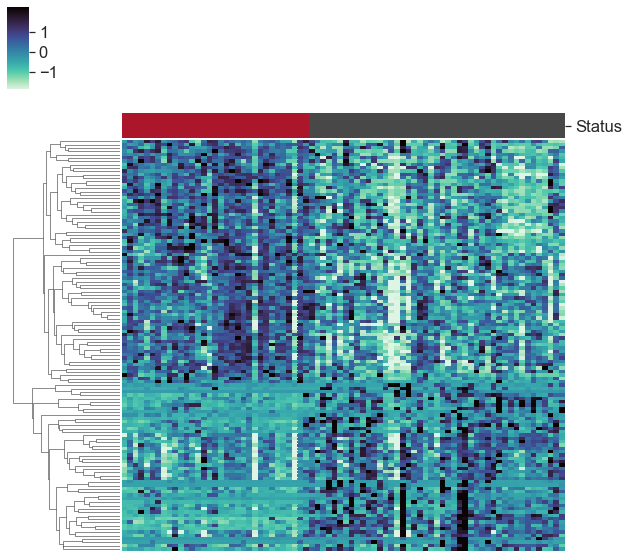

In [139]:
Heatmap(phgg, emtDE, phggDict, '', '', 1.5, (10,10), 
       pal=[sns.color_palette('RdGy', 10)[0],sns.color_palette('RdGy', 10)[9]],
      colormap='mako_r', geneCluster=True, vMinMax=(None,None), ticks=[-1,0,1])

## Figure 1C

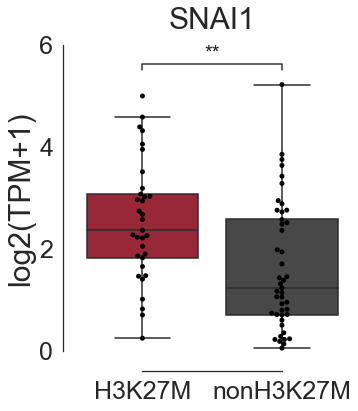

In [152]:
Boxplot(phgg, 'SNAI1', phggDict, 'SNAI1', 'log2(TPM+1)', '', (5,6),
        color=[sns.color_palette('RdGy', 10)[0],sns.color_palette('RdGy', 10)[9]], swarmSize=5 )

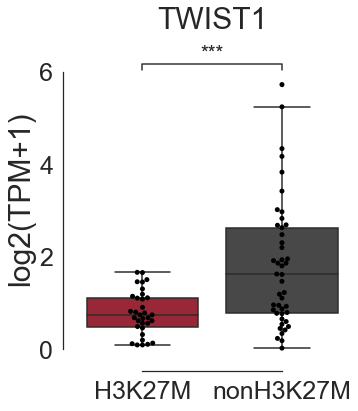

In [153]:
Boxplot(phgg, 'TWIST1', phggDict, 'TWIST1', 'log2(TPM+1)', '', (5,6),
        color=[sns.color_palette('RdGy', 10)[0],sns.color_palette('RdGy', 10)[9]], swarmSize=5 )

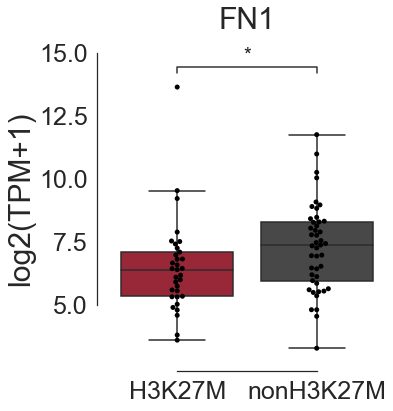

In [154]:
Boxplot(phgg, 'FN1', phggDict, 'FN1', 'log2(TPM+1)', '', (5,6),
        color=[sns.color_palette('RdGy', 10)[0],sns.color_palette('RdGy', 10)[9]], swarmSize=5 )

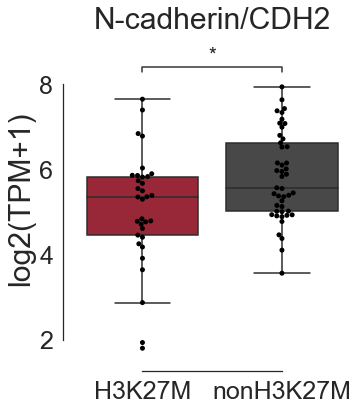

In [156]:
Boxplot(phgg, 'CDH2', phggDict, 'N-cadherin/CDH2', 'log2(TPM+1)', '', (5,6),
        color=[sns.color_palette('RdGy', 10)[0],sns.color_palette('RdGy', 10)[9]], swarmSize=5 )

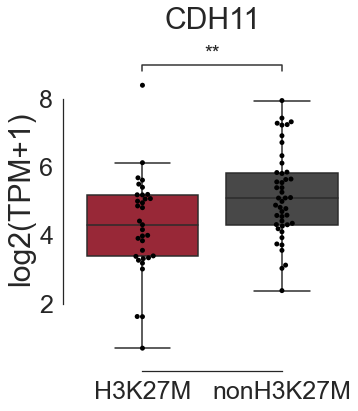

In [155]:
Boxplot(phgg, 'CDH11', phggDict, 'CDH11', 'log2(TPM+1)', '', (5,6),
        color=[sns.color_palette('RdGy', 10)[0],sns.color_palette('RdGy', 10)[9]], swarmSize=5 )

# Figure 2

## Figure 2A

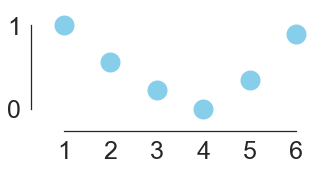

In [29]:
Swarmplot(bulkNorm, 'SNAI1', bulkDict, '', dotColor='skyblue')

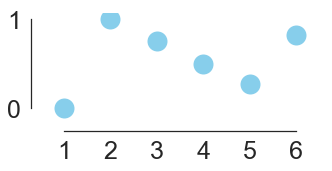

In [30]:
Swarmplot(bulkNorm, 'TWIST1', bulkDict, '', dotColor='skyblue')

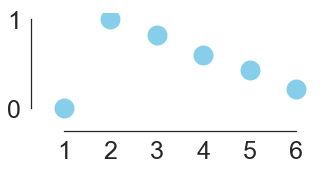

In [31]:
Swarmplot(bulkNorm, 'CDH2', bulkDict, '', dotColor='skyblue')

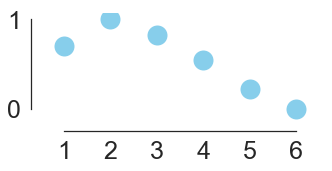

In [32]:
Swarmplot(bulkNorm, 'FN1', bulkDict, '', dotColor='skyblue')

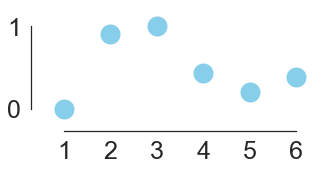

In [33]:
Swarmplot(bulkNorm, 'CDH11', bulkDict, '', dotColor='skyblue')

## Figure 2C

In [72]:
# Score organoid cells by a list of EMT completness genes
scOrgScores = scoreCells(scOrgFil, emtCom)
scOrgScores.shape

(1, 7650)

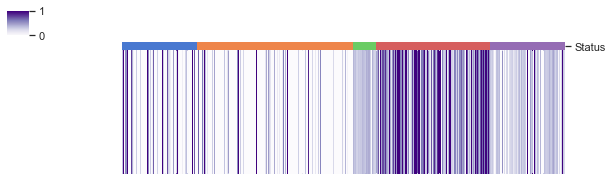

In [129]:
Heatmap(scOrgScores, [0], scOrgDict, '', '', 1, (10,3),
       pal=sns.color_palette('muted'), colormap='Purples', geneCluster=False, vMinMax=(0,1), ticks=[0,1])

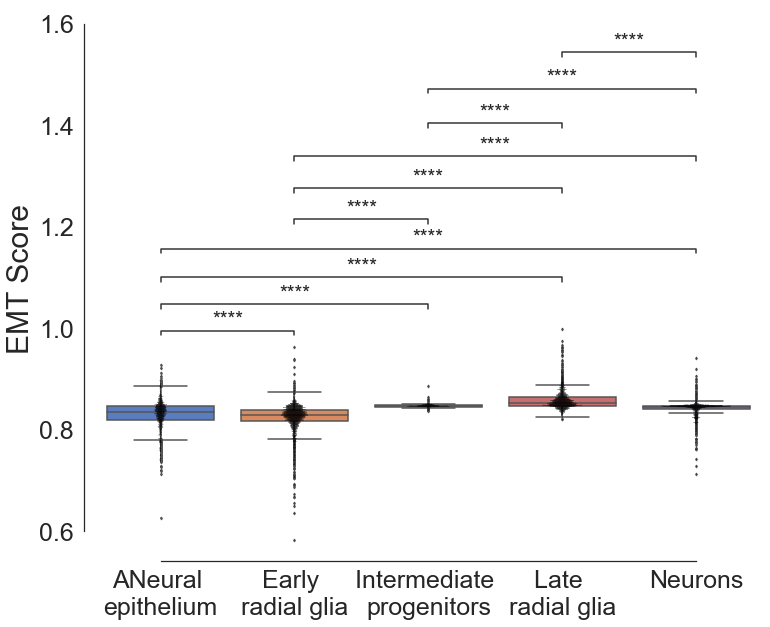

In [133]:
Boxplot(scOrgScores, 0, scOrgDict, '', 'EMT Score', '', (12,10), 
        color=sns.color_palette('muted'), swarmSize=0.6)

## Figure 2D

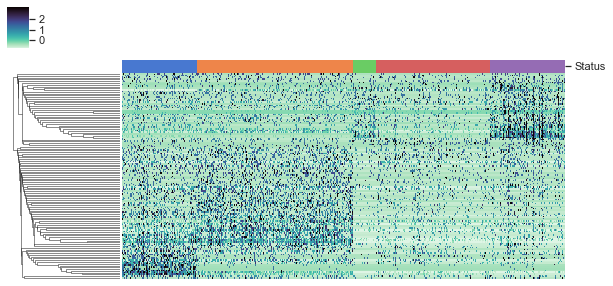

In [134]:
Heatmap(scOrgFil, list(scOrgFil.loc[scOrgFil.index.intersection(k27mUp)].index), 
        scOrgDict, '', '', 1, (10,5),
        pal=sns.color_palette('muted'), colormap='mako_r', geneCluster=True, vMinMax=(None,None), ticks=[0,1,2])

# Figure 3

## Figure 3A


### Dendrogram
Cluster the scGlioma RNA seq samples by expression of EMT genes.

Inspired by Valentine Svensson's work "Extract Cluster Elements by Color in Python Dendrograms", 2014 nxn.se/valent/

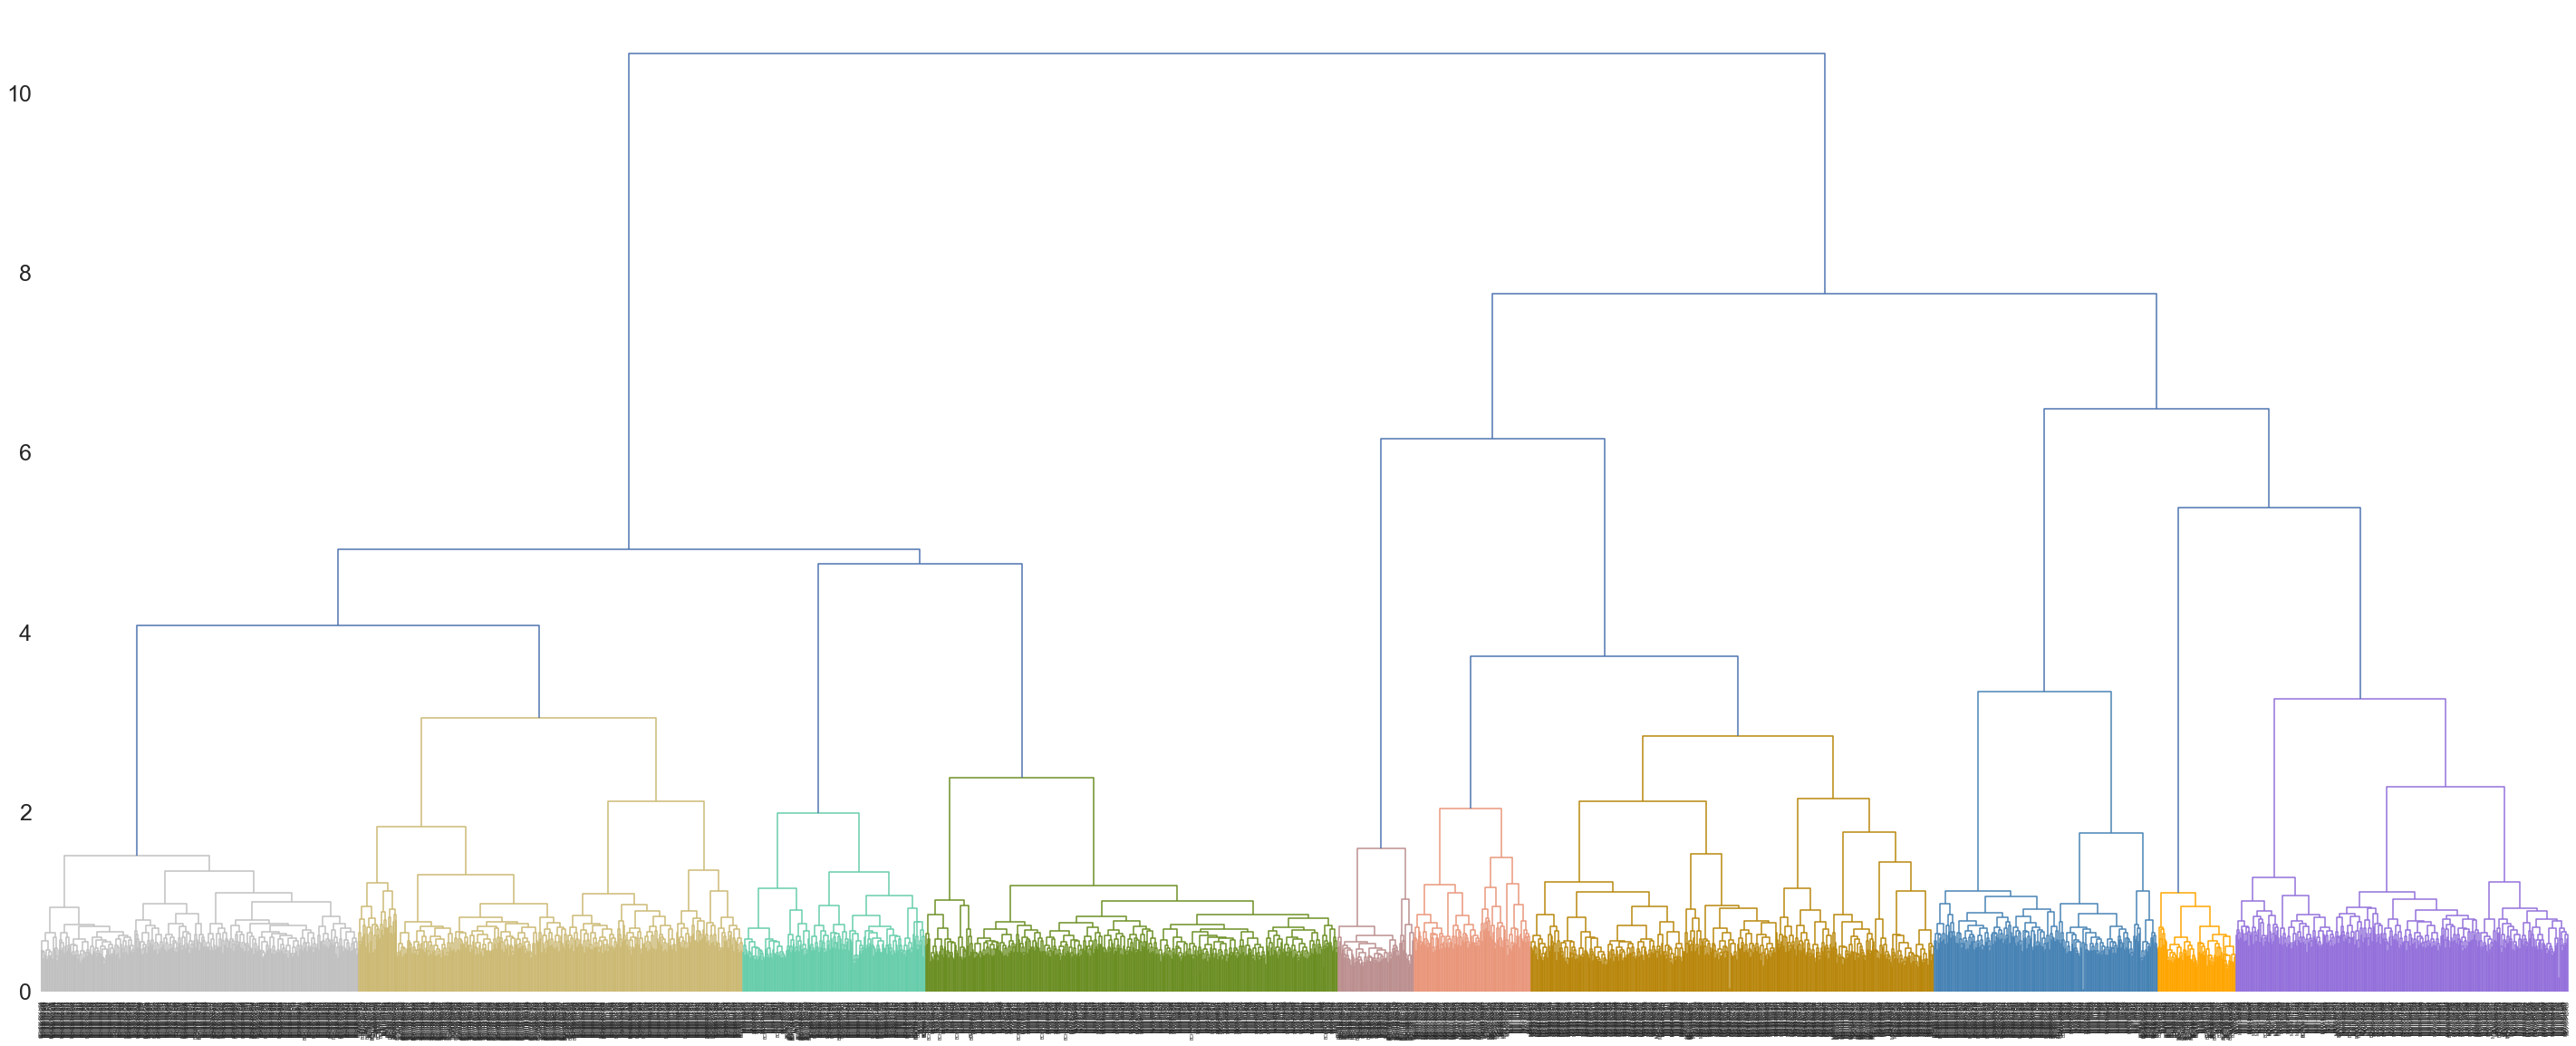

In [157]:
# Set colors
set_link_color_palette(['silver', 'y', 'mediumaquamarine', 'olivedrab', 'rosybrown', 'darksalmon', 'darkgoldenrod', 'steelblue', 'orange', 'mediumpurple'])
sns.set_style('white')

# Calculate linkages
link = linkage(scGlioma.loc[scGlioma.index.intersection(emtMaster)].transpose(), metric='correlation', method='ward')

# Plot dendrogram 
figure(figsize=(50,20), facecolor='w')
dendr = dendrogram(link, labels=scGlioma.transpose().index, color_threshold=3.5) 
plt.xticks(rotation=90)
no_spine = {'left': True, 'bottom': True, 'right': True, 'top': True}
sns.despine(**no_spine);


In [158]:
# Get cluster assignments from dendrogram
clusterIndex = defaultdict(list)
for c, pi in zip(dendr['color_list'], dendr['icoord']):
    for leg in pi[1:3]:
        i = (leg - 5.0) / 10.0
        if abs(i - int(i)) < 1e-5:
            clusterIndex[c].append(int(i))
            
allClusters = [] 
for c, l in clusterIndex.items():
    i_l = [dendr['ivl'][i] for i in l]
    allClusters.append(i_l)

len(allClusters)


10

In [159]:
# Dictionary relating cluster name and sample
dendrDict = {}
alphabet = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
i = 0
for cluster in allClusters:
    for sample in cluster:
        dendrDict[sample] = alphabet[i]
    i += 1


### Cluster expression signatures 
For all genes in the EMT master list that passed the scGlioma RNA seq filter, assign each gene to a cluster based on maximum mean expression.

In [160]:
clusterNames = ['A','B','C','D','E','F','G','H','I','J']
geneClusterDict = {} 
for gene in scGlioma.loc[scGlioma.index.intersection(emtMaster)].index: 
    meanGene = [] 
    
    # get mean gene exp for each cluster
    for clust in clusterNames: 
        meanGene.append(np.mean(list(scGlioma[[x for x in dendrDict if dendrDict[x] == clust]].loc[gene]))) 
        
    # find cluster with max expression for that gene
    maxCluster = clusterNames[meanGene.index(max(meanGene))]  
    
    # dictionary relating cluster assignment for each gene
    geneClusterDict[gene] = maxCluster        


In [161]:
# Get gene list ordered by cluster
genesOrdByCluster = []
for clust in clusterNames:
    for x in geneClusterDict:
        if geneClusterDict[x] == clust:
            genesOrdByCluster.append(x)

### Heatmap

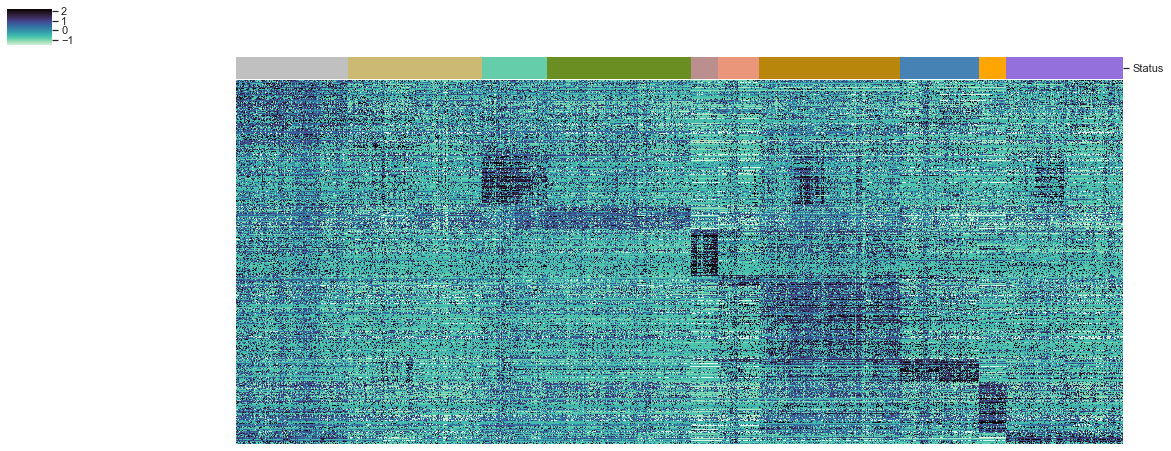

In [168]:
colors = ['silver', 'y', 'mediumaquamarine', 'olivedrab', 
          'rosybrown', 'darksalmon', 'darkgoldenrod', 'steelblue', 'orange', 'mediumpurple']

Heatmap(scGlioma, genesOrdByCluster, dendrDict, '', '', 1, (20,8), pal=colors, 
        colormap='mako_r', geneCluster=False, vMinMax=(None,None), ticks=[-1,0,1,2])

EMT score bar --- 

In [166]:
# Score glioma cells by a list of EMT completness genes
scGliScores = scoreCells(scGlioma, emtCom)
scGliScores.shape

(1, 3057)

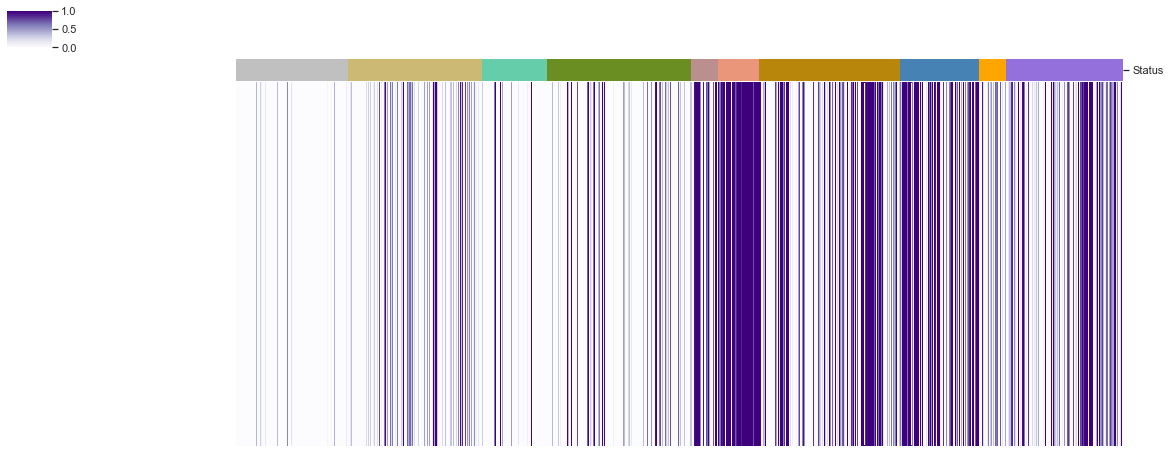

In [172]:
Heatmap(scGliScores, [0], dendrDict, '', '', 1, (20,8), pal=colors, 
        colormap='Purples', geneCluster=False, vMinMax=(0,1), ticks=[0,0.5,1])

Mutation status bar --- 

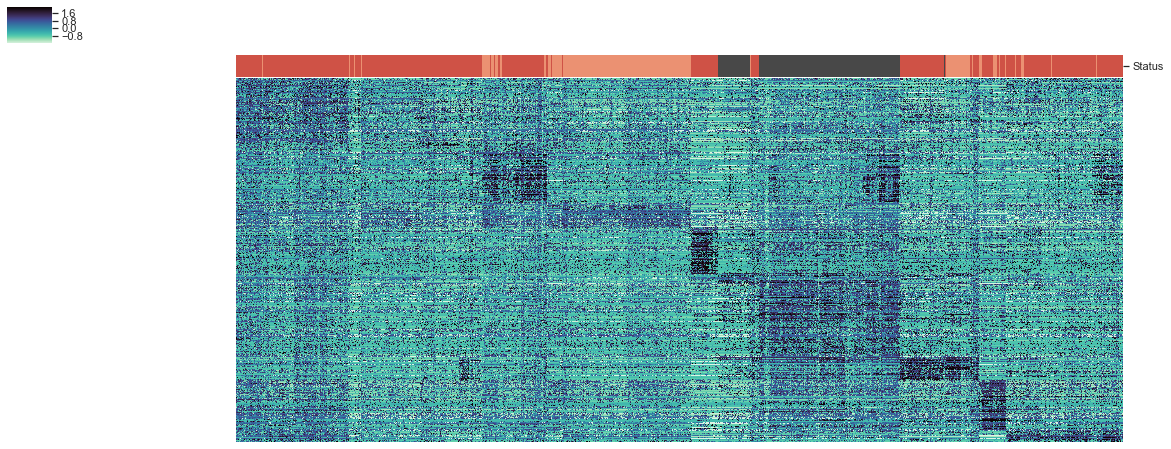

In [171]:
# subset expression to EMT genes and reorder by cluster assignment
dfSub = scGlioma.loc[scGlioma.index.intersection(genesOrdByCluster)].reindex(genesOrdByCluster)[list(dendrDict.keys())]

# Get mutation status
stat = pd.DataFrame(pd.Series(scGliomaDict))
stat.rename(columns={ stat.columns[0]: "Status" }, inplace=True)
statOnly = stat.pop('Status')

# Heatmap
pal=[sns.color_palette("RdGy", 10)[1],sns.color_palette("RdGy", 10)[2],sns.color_palette("RdGy", 10)[9]]
lut = dict(zip(statOnly.unique(), pal))
col_colors = statOnly.map(lut)    
g = sns.clustermap(dfSub, cmap='mako_r',
                    z_score=0, col_colors=col_colors, xticklabels=False, yticklabels=False,
                   metric='correlation', col_cluster=False, row_cluster=False, 
                   robust=True, square=False, figsize=(20,8))

plt.savefig('',dpi=300,bbox_inches="tight")

## Figure 3B

In [48]:
sc.settings.verbosity = 0
sc.settings.set_figure_params(dpi=80, fontsize=28)

In [49]:
# create scanpy anndata object from glioma single cell data subset to EMT genes
annData = sc.AnnData(scGlioma.loc[scGlioma.index.intersection(emtMaster)].transpose())
annData

AnnData object with n_obs × n_vars = 3057 × 629 

In [50]:
# add cluster annotations from dictionary
annData.obs['cluster'] = pd.DataFrame(pd.Series(dendrDict)).reindex(list(annData.obs.index))[0]

In [51]:
# add mutation annotations from dictionary
annData.obs['mutation'] = pd.DataFrame(pd.Series(scGliomaDict)).reindex(list(annData.obs.index))[0]

In [52]:
# add EMT score annotations 
annData.obs['score'] = scGliScores.transpose()[0]

In [53]:
# calculate principal components and neighborhood graph clustering
sc.tl.pca(annData, svd_solver='arpack')
sc.pp.neighbors(annData, n_neighbors=10, n_pcs=10) 
sc.tl.umap(annData)
sc.tl.leiden(annData, resolution=0.5) 

... storing 'cluster' as categorical
... storing 'mutation' as categorical


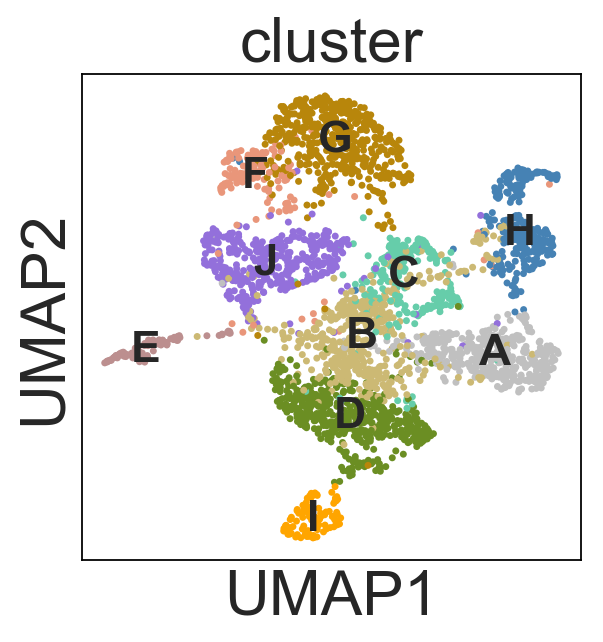

In [54]:
# Plot clusters
colors = ['silver', 'y', 'mediumaquamarine', 'olivedrab', 
          'rosybrown', 'darksalmon', 'darkgoldenrod', 'steelblue', 'orange', 'mediumpurple']

sc.pl.umap(annData, color='cluster', legend_fontsize=20, 
           palette=colors, legend_loc='on data', save='')

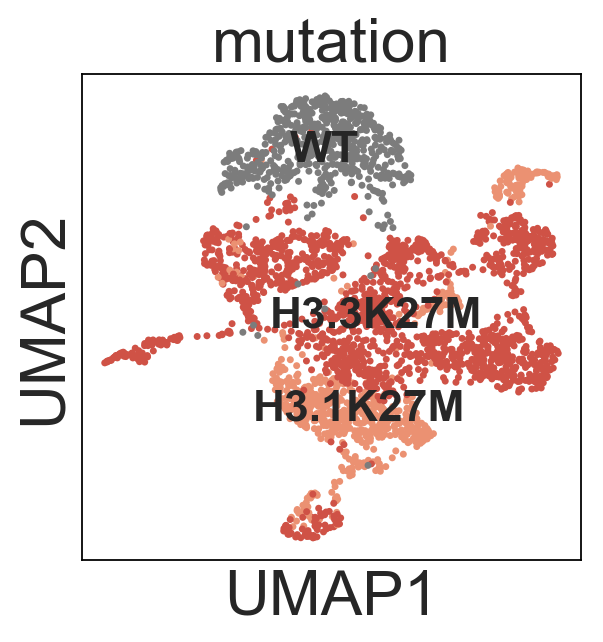

In [55]:
# Plot mutation status
mutationColors = [sns.color_palette("RdGy", 10)[2], 
                  sns.color_palette("RdGy", 10)[1], 
                  sns.color_palette("RdGy", 10)[8]]

sc.pl.umap(annData, color='mutation', palette=mutationColors, legend_fontsize=20, 
           legend_loc='on data', save='')

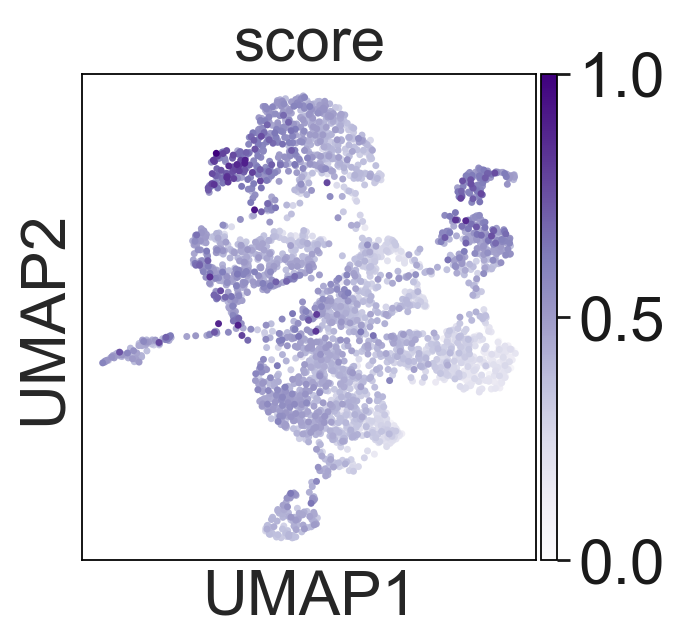

In [56]:
# Plot EMT score
sc.pl.umap(annData, color='score', legend_fontsize=20, 
           cmap='Purples', save='')

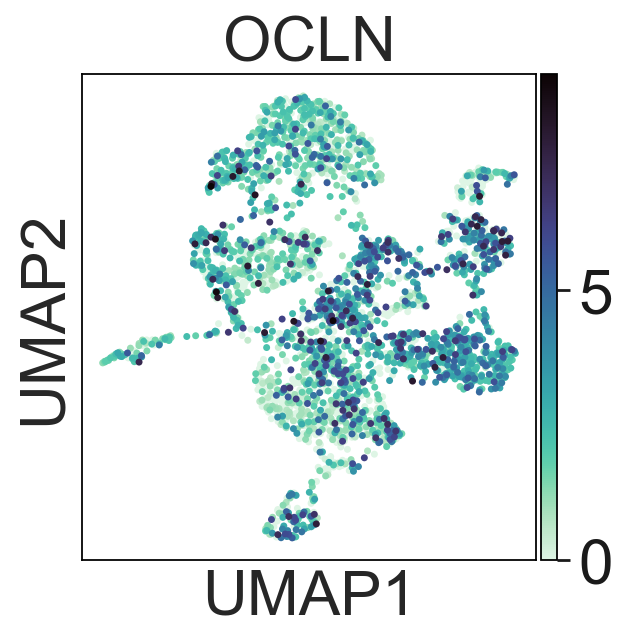

In [57]:
sc.pl.umap(annData, cmap='mako_r', color=['OCLN'],
           save='')

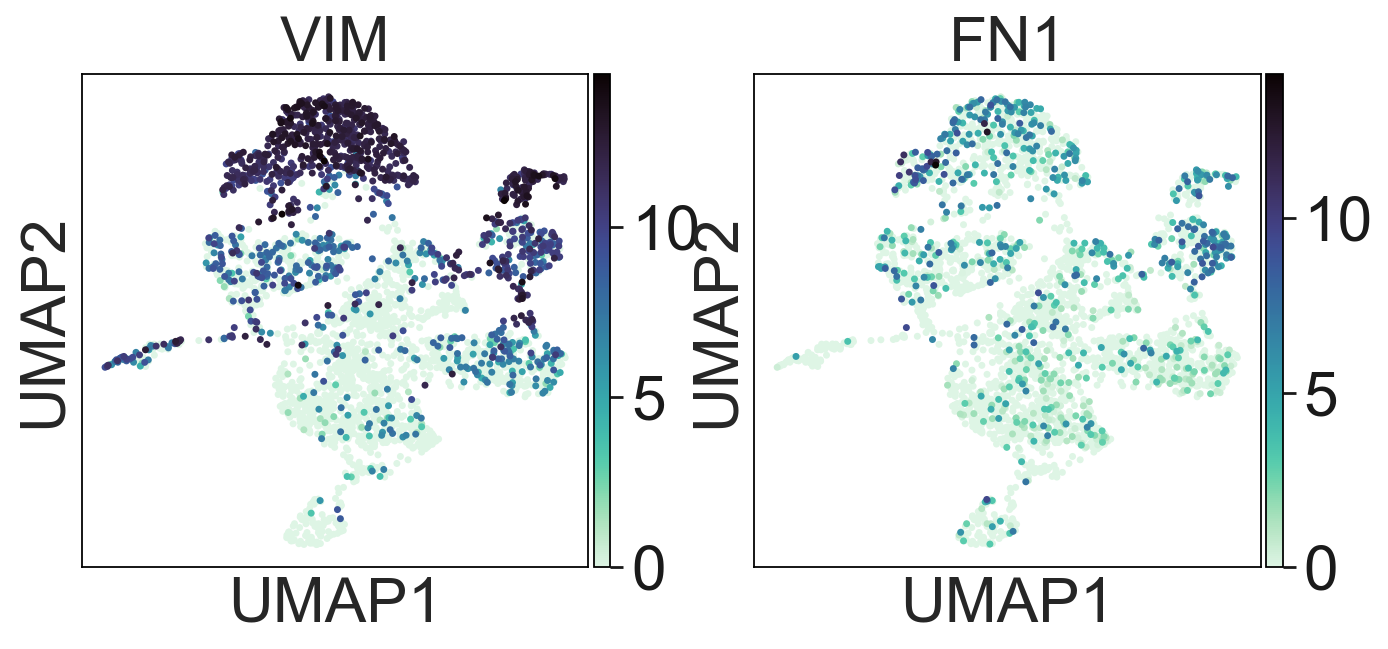

In [58]:
sc.pl.umap(annData, cmap='mako_r', color=['VIM', 'FN1'],
           save='')

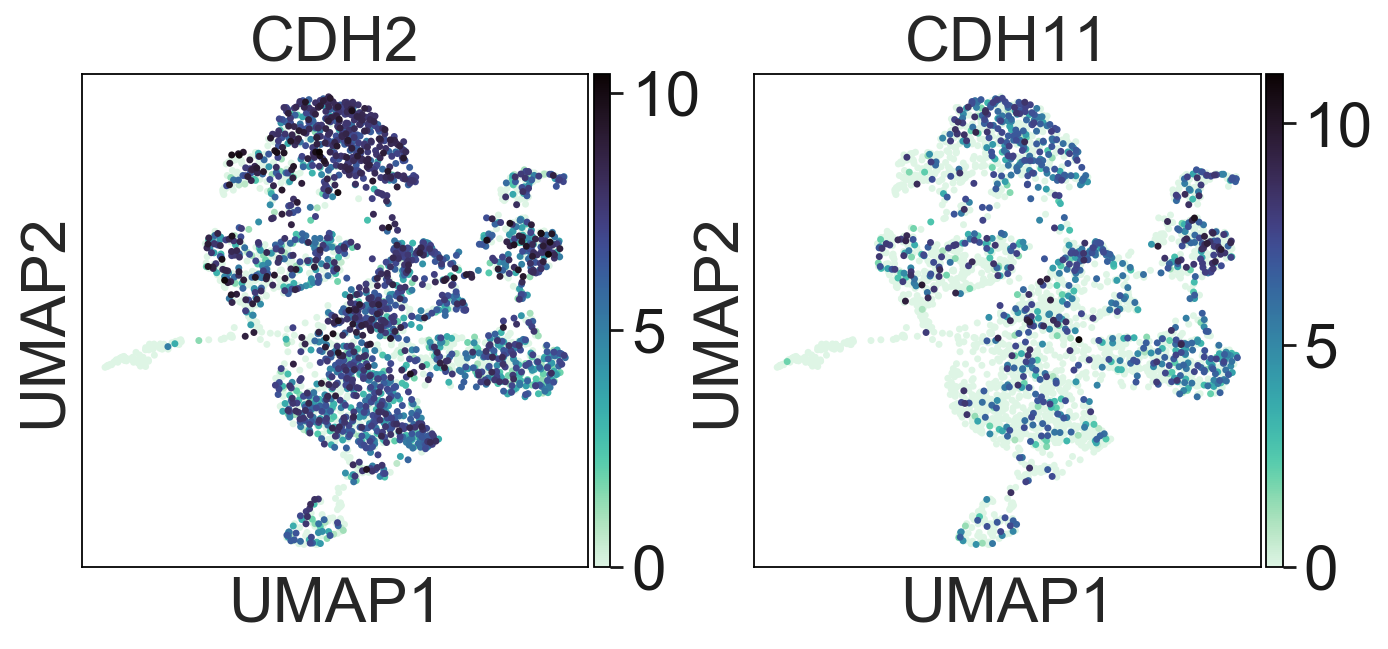

In [59]:
sc.pl.umap(annData, cmap='mako_r', color=['CDH2', 'CDH11'],
           save='')

# Figure 4

## Figure 4A

In [60]:
annData_sub = annData[annData.obs['mutation'] != 'WT',:]
annData_sub

View of AnnData object with n_obs × n_vars = 2458 × 629 
    obs: 'cluster', 'mutation', 'score', 'leiden'
    uns: 'pca', 'neighbors', 'umap', 'leiden', 'cluster_colors', 'mutation_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

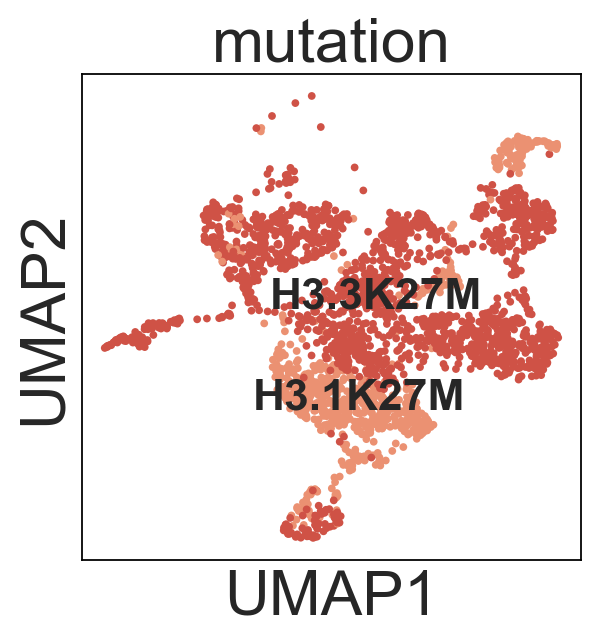

In [61]:
sc.pl.umap(annData_sub, color='mutation', palette=mutationColors, legend_fontsize=20, 
           legend_loc='on data', save='')

## Figure 4B & Figure S1

In [62]:
# Find genes significantly over expressed in the H3.3 K27M cells vs. H3.1 K27M, and vice versa
sc.tl.rank_genes_groups(annData_sub, 'mutation', method='wilcoxon')

# Write out the genes differentially expressed in each group (see Supplementary Table 4)
#pd.DataFrame(annData_sub.uns['rank_genes_groups']['names']).to_csv('filename.csv', sep=",",header=True)

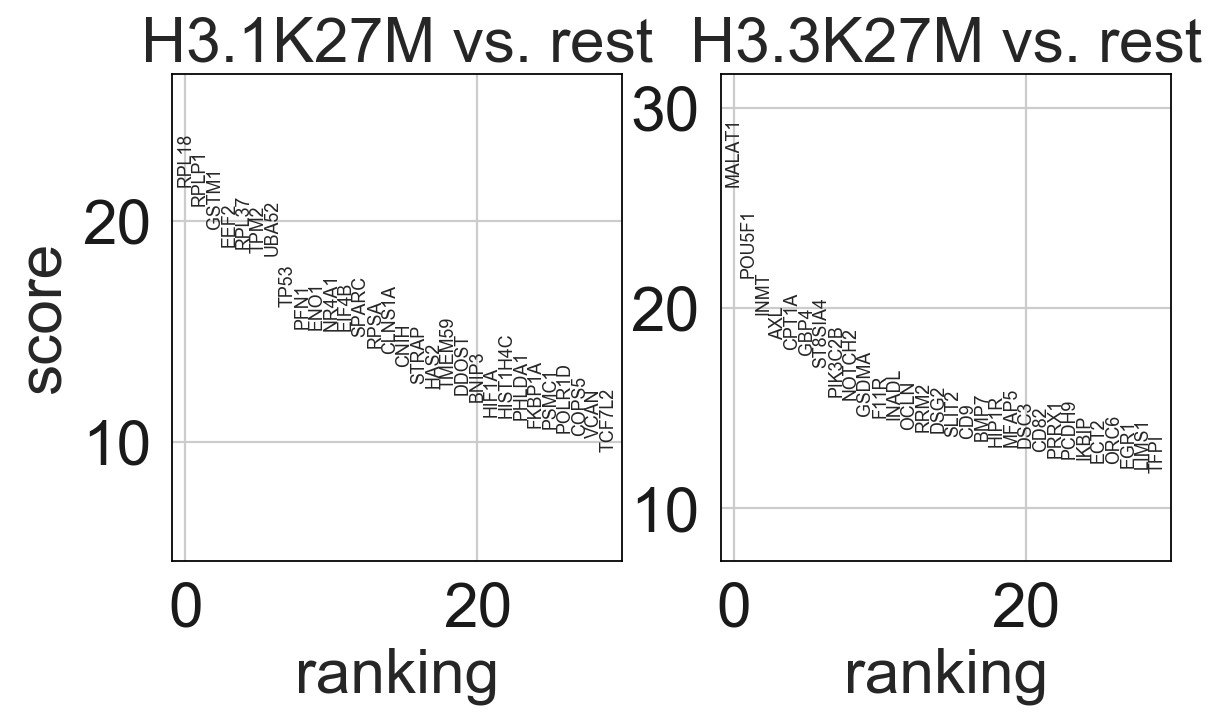

In [63]:
# Supplementary Figure 1
sc.pl.rank_genes_groups(annData_sub, n_genes=30, sharey=False, save='')


In [64]:
# pathways enriched in genes differentially expressed between H3.3 K27M and H3.1 K27M clusters 
# derived from Supplementary table 4
h33up = pd.read_csv('files/glioma.sc.H3.3overH3.1.csv',sep=',')
h31up = pd.read_csv('files/glioma.sc.H3.1overH3.3.csv',sep=',')

Figure 4B ---- 

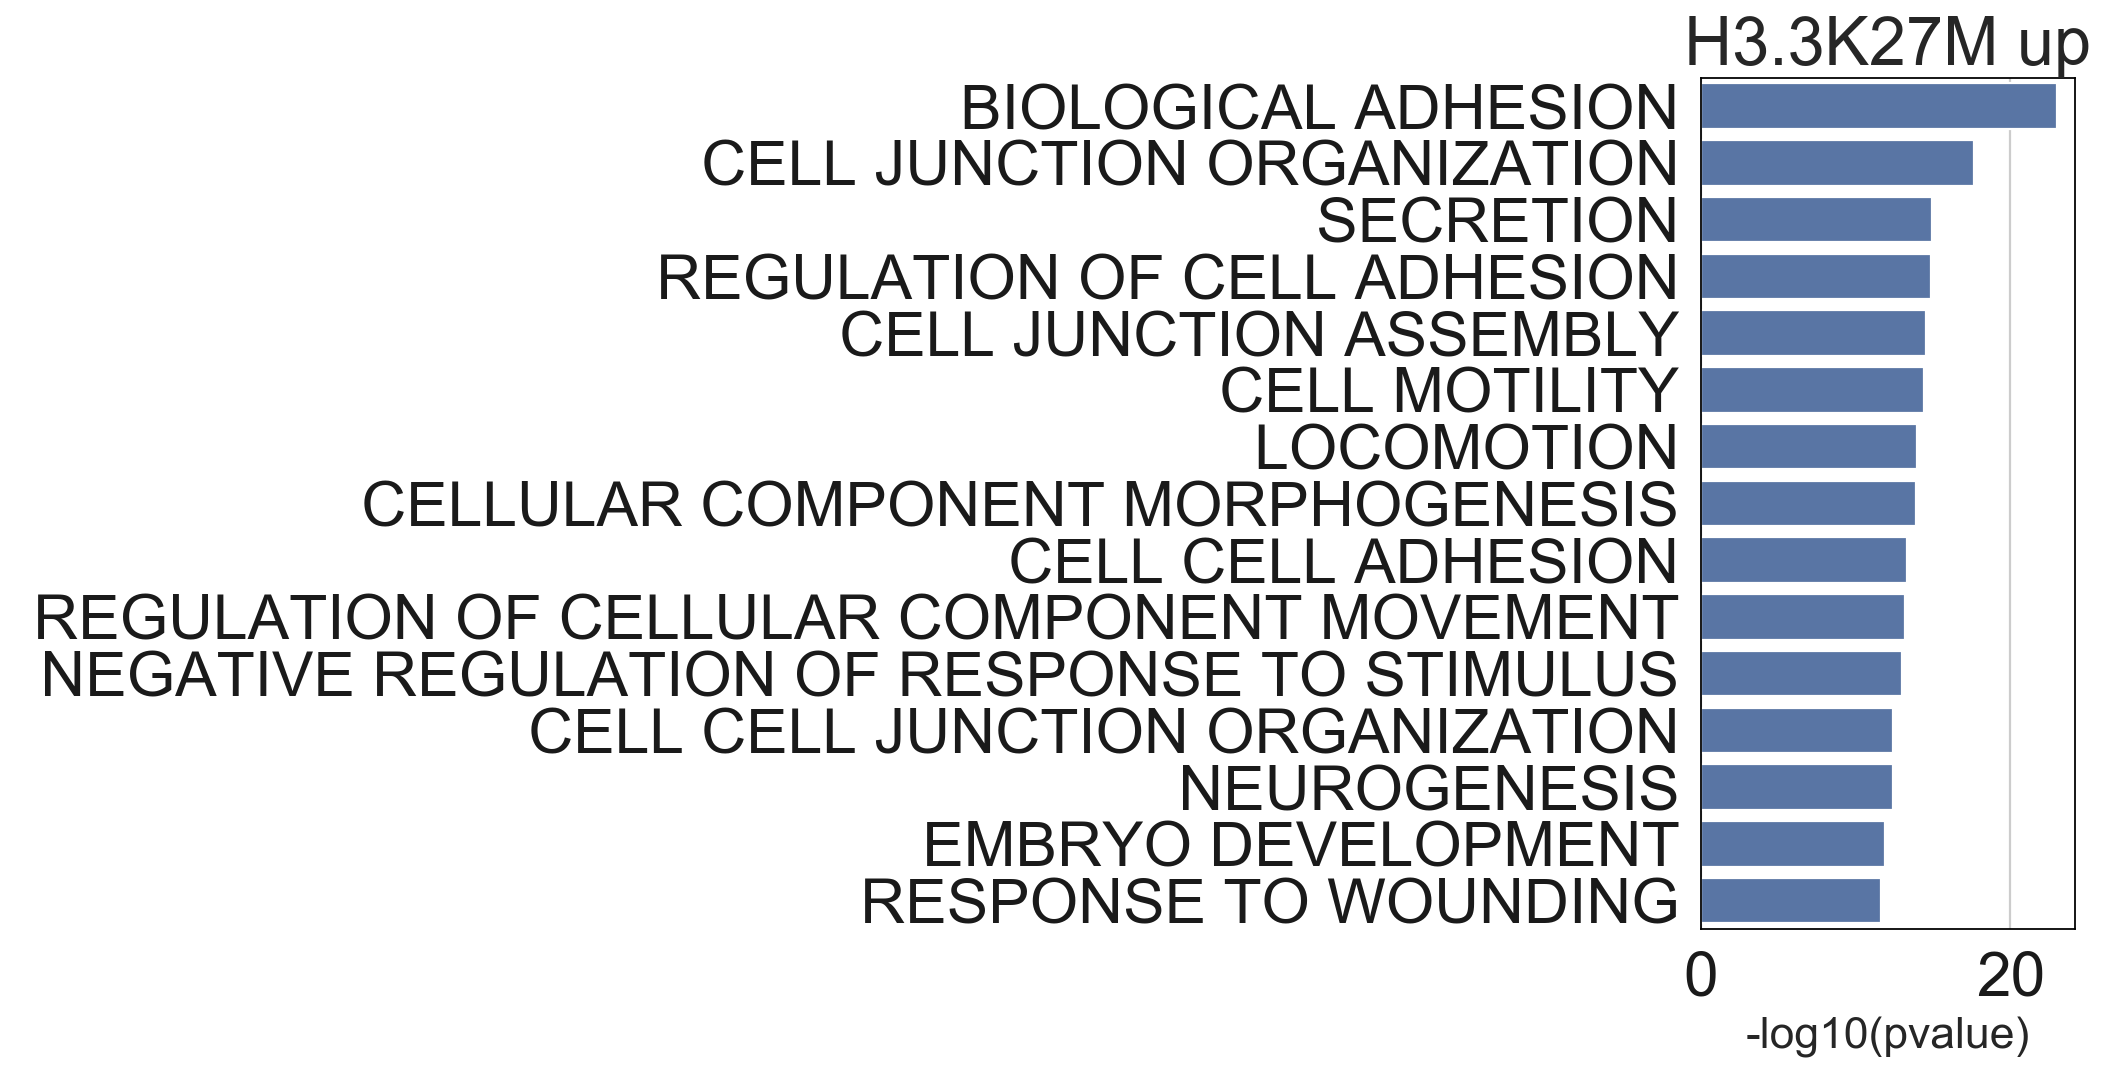

In [65]:
f, ax = plt.subplots(figsize=(3,7))
plt.rc('xtick', labelsize=20)  
plt.rc('ytick', labelsize=20) 

sns.barplot(x='pvalue(-log10)', y='pathway', data=h33up, color='b')

ax.set_ylabel('')
ax.set_xlabel('-log10(pvalue)',fontsize=20)

ax.set_title('H3.3K27M up',fontsize=30)

plt.savefig('', dpi=500, bbox_inches='tight')

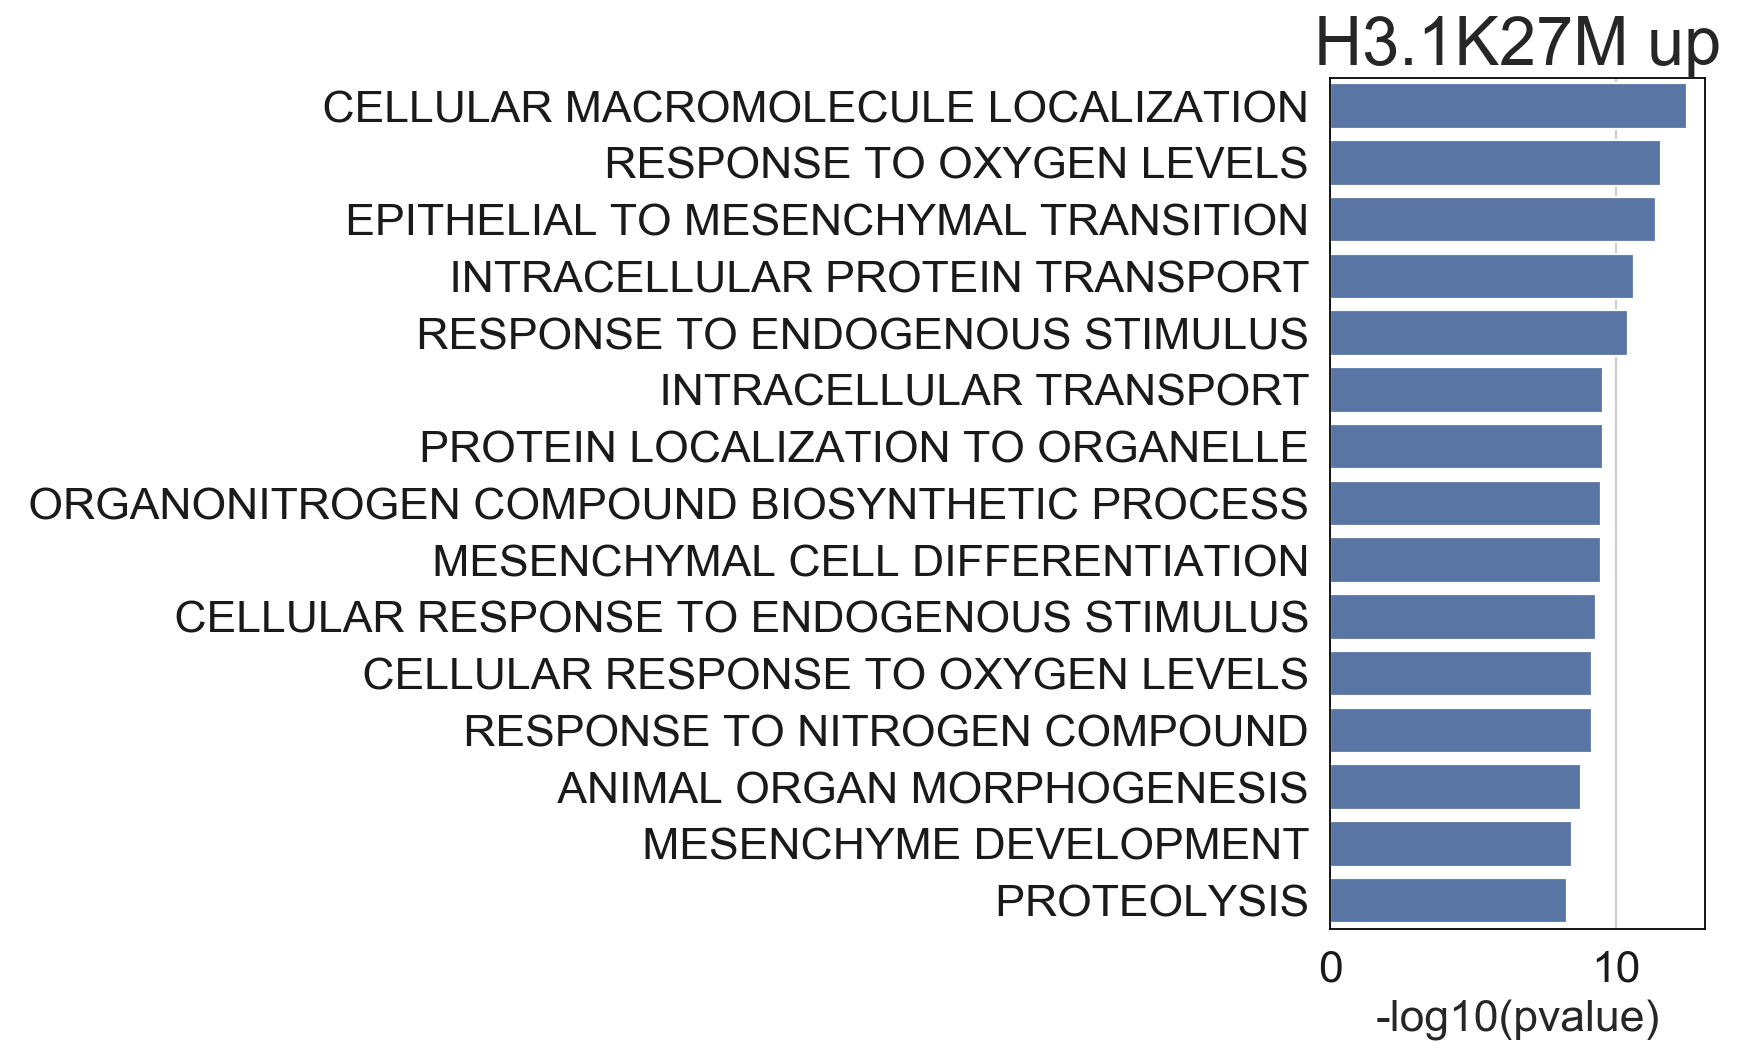

In [66]:
f, ax = plt.subplots(figsize=(3,7))
plt.rc('xtick', labelsize=20)  
plt.rc('ytick', labelsize=20)  

sns.barplot(x='pvalue(-log10)', y='pathway', data=h31up, color='b')

ax.set_ylabel('')
ax.set_xlabel('-log10(pvalue)',fontsize=20)

ax.set_title('H3.1K27M up',fontsize=30)

plt.savefig('', dpi=500, bbox_inches='tight')

## Figure 4D

In [173]:
# Score glioma cell line samples by a list of EMT completness genes
gliomaCellLineScores = scoreCells(cl, emtCom)
gliomaCellLineScores.shape

(1, 11)

In [174]:
mutationColors = [sns.color_palette("RdGy", 10)[2], 
                  sns.color_palette("RdGy", 10)[1], 
                  sns.color_palette("RdGy", 10)[8]]

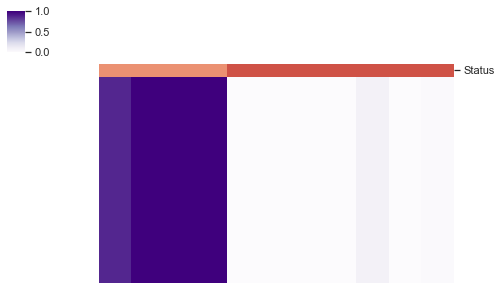

In [178]:
Heatmap(gliomaCellLineScores, [0], clDict, '', '', 1, (8,5), pal=mutationColors, 
        colormap='Purples', geneCluster=False, vMinMax=(0,1), ticks=[0,0.5,1])

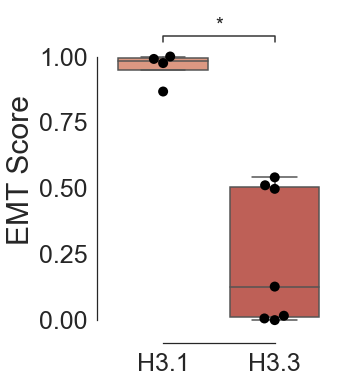

In [177]:
Boxplot(gliomaCellLineScores, 0, clDict, '', 'EMT Score', '', (4,6),
        color=[sns.color_palette('RdGy', 10)[2],sns.color_palette('RdGy', 10)[1]], swarmSize=10 )

# Figure S2

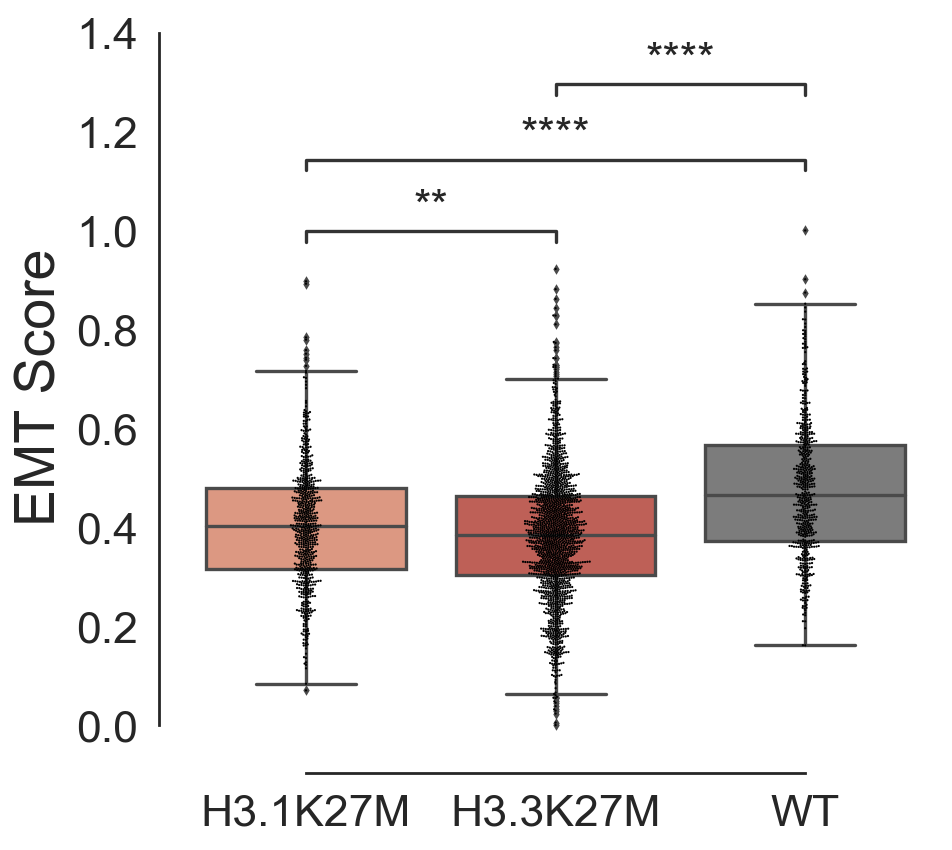

In [71]:
Boxplot(scGliScores, 0, scGliomaDict, '', 'EMT Score', '', (6,6),
        color=mutationColors, swarmSize=1 )